## Instalación de dependencias (Sólo para Google Colab)

La mayor parte del taller utilizaremos principalmente la librería [Pandas](https://pandas.pydata.org/) para el análisis de datos, esta librería viene incluida en el stack que nos provee automáticamente COlab. Sin embargo, para poder leer datos geográficos y hacer mapas, vamos a necesitar instalar [Geopandas](https://geopandas.org/), que es una extensión de Pandas para el manejo de datos geográficos, y un par de librerías más para hacer mapas interactivos. 

La instalación de dependencias en Colab es relativamente sencilla, el caso de Geopandas tiene elguna complicación porque requiere de la instalación de un par de librerías del sistema (es decir, librerías que no son sólo de Python). La siguiente celda contiene las instrucciones (al sistema operativo debajo de Colab, noten el símbolo `!` al inicio de cada instrucción) para instalar todas las dependencias que necesitamos.

````
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
!pip install mapclassify
````

Con todas las librerías instaladas, podemos importar lo que vamos a utilizar

In [9]:
import os
import glob
import itertools
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import timedelta, date, datetime
import csv
import openpyxl
import requests
import matplotlib.pyplot as plt
import mapclassify
import folium

import logging

# Mapas

Lo primero que necesitamos para empezar a hacer mapas y análisis geoespaciales es una librería que nos permita leer y manipular información geográfica. En este caso vamos a usar [Geopandas](https://geopandas.org/en/stable/) que es una especie de extensión de Pandas que nos permite crear DataFrames con una columna de geometría. 

Para empezar a familiarizarnos con la librería, vamos a bajar un [geoJSON](https://geojson.org/) (algo similar al shapefile)

In [3]:
url = "https://www.dropbox.com/s/2zw0fh3vdl0rxh4/municipios_pob_2020_simple.json?dl=1"
r = requests.get(url, allow_redirects=True)
open('data/municipios_pob_2020_simple.json', 'wb').write(r.content)

25803141

## Un mapa sencillo

Ahora ya tenemos el _shape_, vamos a usar GeoPandas para leerlo en un GeoDataFrame

In [4]:
municipios = gpd.read_file('data/municipios_pob_2020_simple.json')
municipios

,id,oid,municipio_cvegeo,municipio,pob2020,pob_0a4,pob_0a9,pob60ym,entidad_cvegeo,geometry
0,827,525,16046,Juárez,15290,1557,3122,1911,16,"POLYGON ((-100.45693 19.33414, -100.45818 19.3..."
1,828,209,16047,Jungapeo,22358,2470,4920,2608,16,"POLYGON ((-100.44063 19.51413, -100.44814 19.5..."
2,829,564,16048,Lagunillas,5862,550,1111,844,16,"POLYGON ((-101.38329 19.59813, -101.38279 19.6..."
3,830,524,16049,Madero,18769,2049,4136,2055,16,"POLYGON ((-101.11644 19.53327, -101.11713 19.5..."
4,67,44,05035,Torreón,744247,65682,129805,85778,05,"MULTIPOLYGON (((-102.98871 24.79622, -102.9930..."
...,...,...,...,...,...,...,...,...,...,...
2452,2452,2388,32053,Villa González Ortega,13945,1481,2926,1599,32,"POLYGON ((-101.94821 22.65201, -101.95269 22.6..."
2453,2453,2417,32054,Villa Hidalgo,20177,2078,4191,2036,32,"POLYGON ((-101.65599 22.51381, -101.65651 22.5..."
2454,2454,1407,32055,Villanueva,31804,2738,5540,5324,32,"POLYGON ((-102.69428 22.62230, -102.69370 22.6..."
2455,2455,2411,32056,Zacatecas,155533,12609,25488,15549,32,"POLYGON ((-102.58542 22.81149, -102.58522 22.8..."


Como pueden ver un GeoDataFrame es bastante similar a un DataFrame, la única diferencia es la columna especial `geometry`. En general cualquier cosa que se puede hacer con un DataFrame de Pandas se puede hacer con un GeoDataFrame (aunque claro, no todas las operaciones regresan algo con geometría!).

Lo primero que vamos a hacer es un mapa rápido de población a nivel municipal. Para eso vamos a usar el métdo [plot](https://geopandas.org/en/stable/docs/user_guide/mapping.html) de geopandas que nos da chance de hacer mapas bien fácil

<AxesSubplot:>

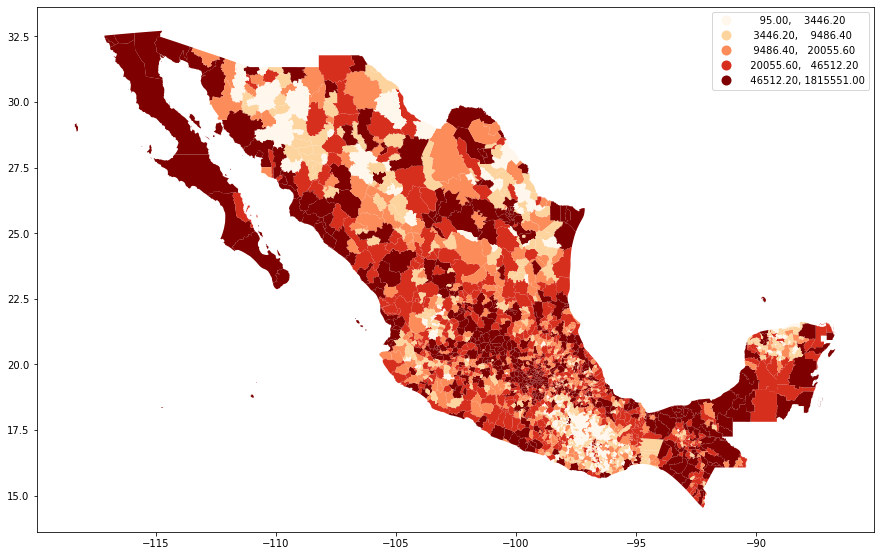

In [5]:
municipios.plot(column='pob2020', cmap='OrRd',figsize=(15, 10), scheme="quantiles", legend=True)

Si no nos gusta cómo se ve el mapa, es fácil hacer modificaciones de estilo

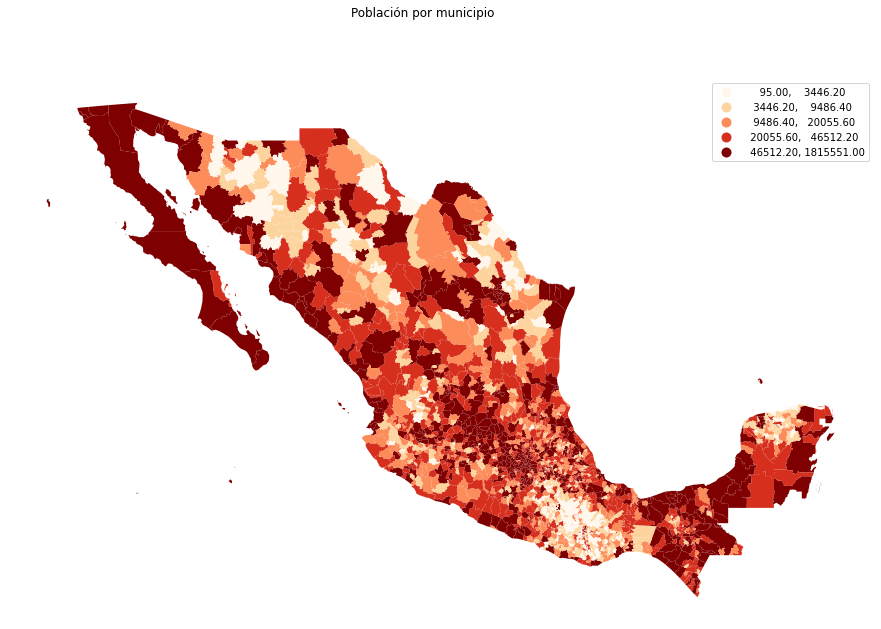

In [12]:
fig, ax = plt.subplots(1, figsize=(20,10))
municipios.plot(column='pob2020', cmap='OrRd',figsize=(15, 10), scheme="quantiles", legend=True, ax=ax)
ax.set_axis_off() 
fig.suptitle("Población por municipio") # A través de la función '.suptitle()' aplicada a la figura se coloca el título.
plt.show()

## Mapas de COVID

El primer paso para mapear los casos de covid es leerlos y unirlos a las geometrías de los municipios, empecemos por leer la misma base que hemos usado ya antes

In [13]:
df = pd.read_pickle("data/datos_covid_ene19_todos.pkl")
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TOMA_MUESTRA_ANTIGENO_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_SINTOMAS,,,,,,,,,,,,,,,,,,,,,
2020-06-24,2022-01-18,z59dea,1,12,CHIAPAS,2,CHIAPAS,CHIAPAS,SAN CRISTÓBAL DE LAS CASAS,AMBULATORIO,...,0,0,0,0,2020,6,2,26,24,176
2020-04-18,2022-01-18,z1e370,1,12,JALISCO,1,JALISCO,JALISCO,TAMAZULA DE GORDIANO,AMBULATORIO,...,0,0,0,0,2020,4,5,16,18,109
2020-07-28,2022-01-18,z5ba5b,2,12,CHIHUAHUA,2,DURANGO,CHIHUAHUA,JUÁREZ,AMBULATORIO,...,0,0,0,0,2020,7,1,31,28,210
2020-08-20,2022-01-18,z1f605,2,12,CHIAPAS,2,CHIAPAS,CHIAPAS,CHANAL,AMBULATORIO,...,0,0,0,0,2020,8,3,34,20,233
2020-05-21,2022-01-18,z4985e,2,12,NUEVO LEÓN,2,NUEVO LEÓN,NUEVO LEÓN,MONTERREY,AMBULATORIO,...,0,0,0,0,2020,5,3,21,21,142


Estos datos corresponden a toda la serie de tiempo, entonces para cada municipio hay toda una serie de valores. Para empezar a hacer mapas entonces vamos a seleccionar una fecha en específico, lo más fácil es seleccionar la última disponible (vamos a seleccionar por `FECHA_INGRESO`, pero podríamos usar cualquier otra)

In [14]:
ultima_fecha = df.loc[df['FECHA_INGRESO'] == df['FECHA_INGRESO'].max()]
ultima_fecha.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TOMA_MUESTRA_ANTIGENO_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_SINTOMAS,,,,,,,,,,,,,,,,,,,,,
2022-01-15,2022-01-18,8a8326,2,3,TABASCO,2,TABASCO,TABASCO,NACAJUCA,AMBULATORIO,...,0,0,0,0,2022,1,5,2,15,15
2022-01-11,2022-01-18,9d8edd,2,12,ZACATECAS,2,ZACATECAS,ZACATECAS,GUADALUPE,AMBULATORIO,...,1,0,0,0,2022,1,1,2,11,11
2022-01-12,2022-01-18,951156,2,12,JALISCO,2,JALISCO,JALISCO,TONALÁ,AMBULATORIO,...,1,0,0,0,2022,1,2,2,12,12
2022-01-15,2022-01-18,e913bd,2,3,TABASCO,1,CHIAPAS,TABASCO,NACAJUCA,AMBULATORIO,...,0,0,0,0,2022,1,5,2,15,15
2022-01-11,2022-01-18,a218ab,2,12,ZACATECAS,2,ZACATECAS,ZACATECAS,TRANCOSO,AMBULATORIO,...,1,0,0,0,2022,1,1,2,11,11


Ahora podemos agregar por municipio para obtener los totales

In [15]:
por_municipio = (ultima_fecha
                 .groupby(['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])['ID_REGISTRO']
                 .size()
                 .reset_index()
                 .rename({"ID_REGISTRO": "Nuevos Casos"}, axis=1)
                 )
por_municipio

,CLAVE_MUNICIPIO_RES,MUNICIPIO_RES,Nuevos Casos
0,03001,COMONDÚ,1
1,03003,LA PAZ,2
2,05017,MATAMOROS,6
3,08032,HIDALGO DEL PARRAL,1
4,09007,IZTAPALAPA,1
5,09017,VENUSTIANO CARRANZA,3
6,10005,DURANGO,3
7,11031,SAN FRANCISCO DEL RINCÓN,2
8,11032,SAN JOSÉ ITURBIDE,3
9,13012,ATOTONILCO EL GRANDE,1


Tenemos la lista de los municipios *que tuvieron* casos en la fecha que estamos analizando, para hacer un mapa necesitamos unir estos datos a la geometría de los municipios.

Primero vamos a seleccionar, a partir del GeoDataFrame que ya tenemos sólo los municipios de la entidad que estamos analizando. A partir de eso podemos realizar una unión via la clave del municipio, sólo tenemos que tener cuiaddo de utilizar el tipo de unión adecuada para no dejar fuera los municipios sin casos.

In [16]:
casos_municipio = (municipios
                   .merge(por_municipio, left_on='municipio_cvegeo', right_on='CLAVE_MUNICIPIO_RES', how='left') # Unimos con los municipios
                   .drop(columns=['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES']) # eliminamos dos columnas que ya no vamosd a usar
                   .fillna(0) # Los municipios sin casos deben tener 0 en lugar de NaN
                   )
casos_municipio

,id,oid,municipio_cvegeo,municipio,pob2020,pob_0a4,pob_0a9,pob60ym,entidad_cvegeo,geometry,Nuevos Casos
0,827,525,16046,Juárez,15290,1557,3122,1911,16,"POLYGON ((-100.45693 19.33414, -100.45818 19.3...",0.0
1,828,209,16047,Jungapeo,22358,2470,4920,2608,16,"POLYGON ((-100.44063 19.51413, -100.44814 19.5...",0.0
2,829,564,16048,Lagunillas,5862,550,1111,844,16,"POLYGON ((-101.38329 19.59813, -101.38279 19.6...",0.0
3,830,524,16049,Madero,18769,2049,4136,2055,16,"POLYGON ((-101.11644 19.53327, -101.11713 19.5...",0.0
4,67,44,05035,Torreón,744247,65682,129805,85778,05,"MULTIPOLYGON (((-102.98871 24.79622, -102.9930...",0.0
...,...,...,...,...,...,...,...,...,...,...,...
2452,2452,2388,32053,Villa González Ortega,13945,1481,2926,1599,32,"POLYGON ((-101.94821 22.65201, -101.95269 22.6...",0.0
2453,2453,2417,32054,Villa Hidalgo,20177,2078,4191,2036,32,"POLYGON ((-101.65599 22.51381, -101.65651 22.5...",0.0
2454,2454,1407,32055,Villanueva,31804,2738,5540,5324,32,"POLYGON ((-102.69428 22.62230, -102.69370 22.6...",0.0
2455,2455,2411,32056,Zacatecas,155533,12609,25488,15549,32,"POLYGON ((-102.58542 22.81149, -102.58522 22.8...",5.0


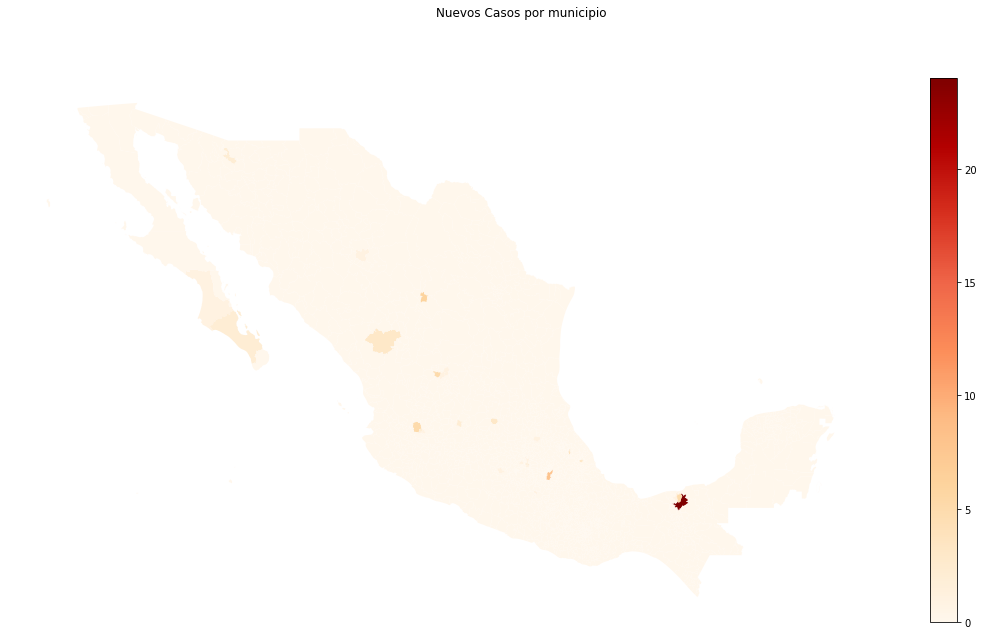

In [18]:
fig, ax = plt.subplots(1, figsize=(20,10))
casos_municipio.plot(column='Nuevos Casos', cmap='OrRd',figsize=(15, 10), legend=True, ax=ax)
ax.set_axis_off() 
fig.suptitle("Nuevos Casos por municipio") # A través de la función '.suptitle()' aplicada a la figura se coloca el título.
plt.show()